In [1]:
# Import Dependencies
import numpy as np
from glob import glob
import pandas as pd
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [68]:
# Check TF 2 Version
tf.__version__

'2.3.0'

In [2]:
# Set Seed
tf.random.set_seed(101)

## Load Dataset

In [3]:
# Base Path where txt files are located
base_path = './'

In [4]:
# Using first 3 folds as training dataset
train_df = pd.concat([pd.read_csv(base_path+"fold_%s_data.txt"%i, sep="\t") for i in range(3)])

In [5]:
train_df.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [6]:
# Using the 3rd fold as Validation dataset
val_df = pd.read_csv(base_path+"fold_3_data.txt", sep="\t")
val_df.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,113445054@N07,11763777465_11d01c34ce_o.jpg,1322,"(25, 32)",m,1102,296,357,357,-15,0,59
1,113445054@N07,11763777465_11d01c34ce_o.jpg,1323,"(25, 32)",f,1713,580,325,325,-5,0,118
2,113445054@N07,11763777465_11d01c34ce_o.jpg,1324,"(15, 20)",f,1437,664,306,306,5,0,109
3,113445054@N07,11764005785_f21921aea6_o.jpg,1325,"(25, 32)",f,978,229,803,803,-20,-45,16
4,113445054@N07,11763728674_a41d99f71e_o.jpg,1326,"(25, 32)",m,1745,910,242,242,-10,0,55


In [7]:
# Using the 4th fold as Testing dataset
test_df = pd.read_csv(base_path+"fold_4_data.txt", sep="\t")
test_df.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,115321157@N03,12111738395_a7f715aa4e_o.jpg,1744,"(4, 6)",m,663,997,637,638,-95,0,129
1,115321157@N03,12112413505_0aea8e17c6_o.jpg,1745,"(48, 53)",m,505,846,433,433,-95,0,72
2,115321157@N03,12112392255_995532c2f0_o.jpg,1744,"(4, 6)",m,517,1185,383,383,0,0,70
3,115321157@N03,12112392255_995532c2f0_o.jpg,1746,"(25, 32)",m,2247,688,376,376,0,30,67
4,115321157@N03,12112392255_995532c2f0_o.jpg,1747,"(25, 32)",m,1421,667,325,325,0,0,102


In [8]:
# Get Training Image Data Path
def create_path(df, base_path):
    df['path'] = df.apply(lambda x: base_path+"faces/"+x['user_id']+"/coarse_tilt_aligned_face.%s.%s"
                                                                      %(x['face_id'], x['original_image']), axis=1)
    return df

In [9]:
# Filter Images by Male/Female
def filter_df(df):
    df['f'] = df.gender.apply(lambda x: int(x in ['f', 'm']))
    df = df[df.f == 1]
    return df

In [10]:
# Filter Dataframes by Gender
train_df = filter_df(train_df)
val_df = filter_df(val_df)
test_df = filter_df(test_df)

In [11]:
train_df.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,f
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17,1
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94,1
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74,1
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47,1
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34,1


In [12]:
val_df

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,f
0,113445054@N07,11763777465_11d01c34ce_o.jpg,1322,"(25, 32)",m,1102,296,357,357,-15,0,59,1
1,113445054@N07,11763777465_11d01c34ce_o.jpg,1323,"(25, 32)",f,1713,580,325,325,-5,0,118,1
2,113445054@N07,11763777465_11d01c34ce_o.jpg,1324,"(15, 20)",f,1437,664,306,306,5,0,109,1
3,113445054@N07,11764005785_f21921aea6_o.jpg,1325,"(25, 32)",f,978,229,803,803,-20,-45,16,1
4,113445054@N07,11763728674_a41d99f71e_o.jpg,1326,"(25, 32)",m,1745,910,242,242,-10,0,55,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3416,7610270@N03,9362346126_f9ef6d731a_o.jpg,1733,"(25, 32)",m,688,1458,669,669,-85,0,95,1
3417,7610270@N03,10162156533_3e27843d55_o.jpg,1734,"(25, 32)",f,619,1281,638,637,195,0,119,1
3418,10466455@N02,11922993085_634a1193fa_o.jpg,1735,"(38, 43)",m,1319,109,1237,1237,-5,0,93,1
3419,10466455@N02,11923013085_05915054c5_o.jpg,1735,"(38, 43)",m,1644,787,262,261,-15,0,76,1


In [13]:
# Get Image Paths
train_df = create_path(train_df, base_path=base_path)
val_df = create_path(val_df, base_path=base_path)
test_df = create_path(test_df, base_path=base_path)

In [14]:
train_df.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,f,path
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17,1,./faces/30601258@N03/coarse_tilt_aligned_face....
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94,1,./faces/30601258@N03/coarse_tilt_aligned_face....
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74,1,./faces/30601258@N03/coarse_tilt_aligned_face....
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47,1,./faces/30601258@N03/coarse_tilt_aligned_face....
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34,1,./faces/30601258@N03/coarse_tilt_aligned_face....


In [15]:
# Function to Read and Resize Image Data
def read_and_resize(filepath, input_shape=(224, 224)):
    im = Image.open((filepath)).convert('RGB')
    im = im.resize(input_shape)
    im_array = np.array(im, dtype="uint8")
    return np.array(im_array / (np.max(im_array)+ 0.001), dtype="float32")

In [16]:
# Read Test Images and Labels
# This will be used at the end for making predictions
test_images = np.array([read_and_resize(file_path) for file_path in test_df.path.values])
test_labels = np.array([int(g == "m") for g in test_df.gender.values])

In [17]:
test_df.gender.values

array(['m', 'm', 'm', ..., 'f', 'f', 'f'], dtype=object)

In [18]:
test_labels

array([1, 1, 1, ..., 0, 0, 0])

### Create TFRecords for Dataset

In [19]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [20]:
def createDataRecord(out_filename, addrs, labels):
    print(len(addrs))
    writer = tf.compat.v1.python_io.TFRecordWriter(out_filename)
    for i in range(len(addrs)):

        img = load_image(addrs[i])

        print(labels[i])
        label = labels[i]

        if img is None:
            break

        # Create a feature
        feature = {
            'image_raw': _bytes_feature(img.tobytes()),
            'label': _int64_feature(label)
        }
       
        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        if not i % 1000:
            print(example)
       
        # Serialize to string and write on the file
        writer.write(example.SerializeToString())

    writer.close()

In [21]:
# Function to Read and Resize Image Data
def load_image(filepath, input_shape=(224, 224)):
    im = Image.open((filepath)).convert('RGB')
    im = im.resize(input_shape)
    im_array = np.array(im, dtype="uint8")
    return np.array(im_array / (np.max(im_array)+ 0.001), dtype="float32")

### TFRecord for Training and Val Data

In [22]:
from random import shuffle

In [23]:
def create_tfrecord(df, record_name=None):
    file_names = df.path.values
    file_labels = np.array([int(g == "m") for g in df.gender.values])
    c = list(zip(file_names, file_labels))
    shuffle(c)
    addrs, labels = zip(*c)
    createDataRecord(record_name, addrs, labels)

In [ ]:
# Create Training TFRecord file
create_tfrecord(train_df, record_name='train_data.tfrecords')

In [ ]:
# Create Validation TFRecord file
create_tfrecord(val_df, record_name='val_data.tfrecords')

## Load the Model

In [24]:
# Load Pre-trained Model
model = tf.keras.models.load_model('./model/vgg_face_keras_hwc.h5')
model.summary()

/Users/anujdutt/miniconda3/envs/Matroid-Challenge/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: onnx2keras.activation_layers is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1_Y_pad (ZeroPadding2D (None, 226, 226, 3)       0         
_________________________________________________________________
conv1_1_Y (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
relu1_1_Y (Activation)       (None, 224, 224, 64)      0         
_________________________________________________________________
conv1_2_Y_pad (ZeroPadding2D (None, 226, 226, 64)      0         
_________________________________________________________________
conv1_2_Y (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
relu1_2_Y (Activation)       (None, 224, 224, 64)     

In [25]:
# Freeze Model Layers
for layer in model.layers:
    layer.trainable = False

In [26]:
# Remove the last Softmax Layer
vgg_faces_model = tf.keras.Model(model.inputs, model.layers[-12].output)
vgg_faces_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1_Y_pad (ZeroPadding2D (None, 226, 226, 3)       0         
_________________________________________________________________
conv1_1_Y (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
relu1_1_Y (Activation)       (None, 224, 224, 64)      0         
_________________________________________________________________
conv1_2_Y_pad (ZeroPadding2D (None, 226, 226, 64)      0         
_________________________________________________________________
conv1_2_Y (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
relu1_2_Y (Activation)       (None, 224, 224, 64)     

In [27]:
# Create and Return the ML Model
def get_model(n_classes=1):
    x = vgg_faces_model.output
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(100, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    if n_classes == 1:
        x = tf.keras.layers.Dense(n_classes, activation="sigmoid")(x)
    else:
        x = tf.keras.layers.Dense(n_classes, activation="softmax")(x)

    base_model = tf.keras.Model(vgg_faces_model.input, x, name="vgg_faces_model")
    if n_classes == 1:
        base_model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer="adam")
    else:
        base_model.compile(loss="sparse_categorical_crossentropy", metrics=['acc'], optimizer="adam")

    return base_model

In [28]:
# Path to store checkpoints
file_path = "./gender_classification.h5"

# Callbacks
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early = EarlyStopping(monitor="val_acc", mode="max", patience=10)

reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=3)

callbacks_list = [checkpoint, early, reduce_on_plateau]  # early

In [29]:
# Get the Model
model = get_model(n_classes=1)

### Model Training

In [30]:
AUTO = tf.data.experimental.AUTOTUNE

In [31]:
# Function to read TFRecords File
def read_tfrecord(example):
    features = {
        "image_raw": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "label": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
    }
    # decode the TFRecord
    parsed_features = tf.io.parse_single_example(example, features)
    img_shape = tf.stack([224, 224, 3])
    image = tf.io.decode_raw(parsed_features['image_raw'], tf.float32)
    image = tf.reshape(image, img_shape)
    label = tf.cast(parsed_features['label'], tf.int32)
    
    return image, label

In [32]:
# Get Data from TFRecord Files in Batches
def get_batched_dataset(filenames):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)

    dataset = dataset.cache()
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(32, drop_remainder=False)
    dataset = dataset.prefetch(AUTO)

    return dataset
  
def get_training_dataset():
    return get_batched_dataset('./train_data.tfrecords')

def get_validation_dataset():
    return get_batched_dataset('./val_data.tfrecords')

In [33]:
# Train the Model
history = model.fit(get_training_dataset(), steps_per_epoch=50, epochs=20,
                      validation_data=get_validation_dataset(), validation_steps=30, callbacks=callbacks_list)

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 0.6449 - acc: 0.6275
Epoch 00001: val_acc improved from -inf to 0.61875, saving model to ./gender_classification.h5
50/50 [==============================] - 241s 5s/step - loss: 0.6449 - acc: 0.6275 - val_loss: 0.5925 - val_acc: 0.6187
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 0.5443 - acc: 0.7194
Epoch 00002: val_acc improved from 0.61875 to 0.84479, saving model to ./gender_classification.h5
50/50 [==============================] - 225s 4s/step - loss: 0.5443 - acc: 0.7194 - val_loss: 0.4393 - val_acc: 0.8448
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 0.4624 - acc: 0.7875
Epoch 00003: val_acc improved from 0.84479 to 0.85000, saving model to ./gender_classification.h5
50/50 [==============================] - 226s 5s/step - loss: 0.4624 - acc: 0.7875 - val_loss: 0.3891 - val_acc: 0.8500
Epoch 4/20
50/50 [==============================] - ETA: 0s - loss: 0.4194 - acc: 

## Trained Model Evaluation

In [36]:
# Model Metrics
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

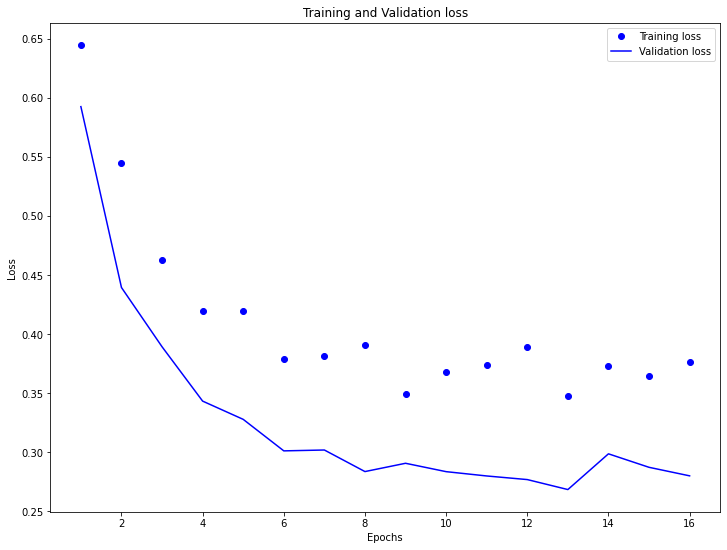

In [37]:
# Plot Training and Validation Loss
plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

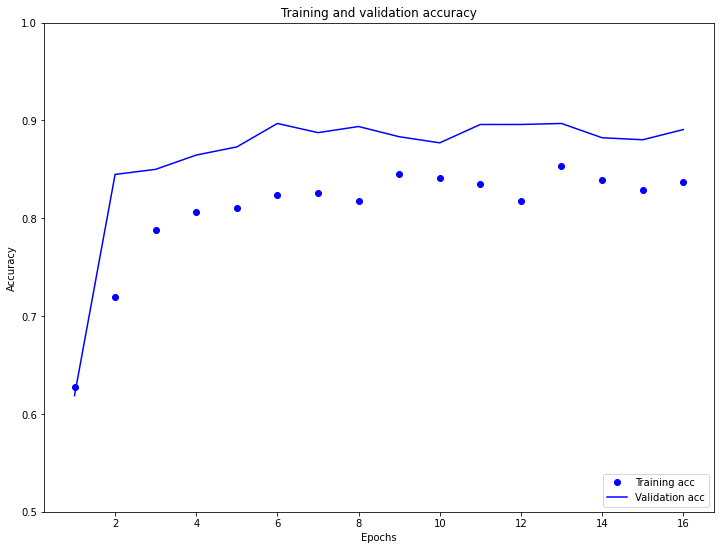

In [38]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [39]:
# Save Trained Model
model.save('final_gender_classification_model.h5')
model.save_weights('final_gender_classification_model_weights.h5')

## Testing the Model

In [40]:
# Test Dataset
test_images.shape

(3445, 224, 224, 3)

In [41]:
# Get Model Predictions on Test Dataset
predictions = model.predict(test_images)

In [47]:
predictions

array([[0.29132938],
       [0.6255329 ],
       [0.8688357 ],
       ...,
       [0.09663978],
       [0.10229939],
       [0.11637765]], dtype=float32)

In [48]:
# Get Predicted Labels from Predictions
# 1 -> Male, 0 -> Female
predicted_labels = []
threshold = 0.5

for i in range(len(predictions)):
    if predictions[i] > threshold:
        predicted_labels.append(1)
    else:
        predicted_labels.append(0)

In [49]:
predicted_labels

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


## Model Evaluation Metrics

In [50]:
from sklearn.metrics import classification_report, confusion_matrix

In [51]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

In [52]:
# Model Classification Performance Report
print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1848
           1       0.85      0.76      0.80      1597

    accuracy                           0.82      3445
   macro avg       0.83      0.82      0.82      3445
weighted avg       0.83      0.82      0.82      3445



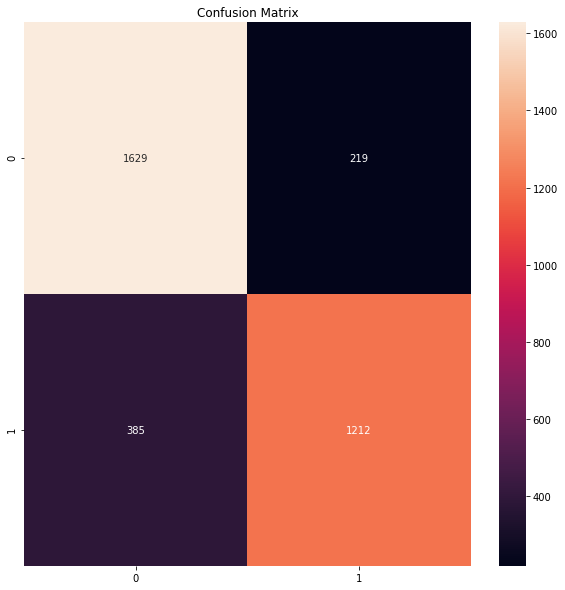

In [60]:
# Plot Confusion Matrix for the Model
import seaborn as sn

df_cm = pd.DataFrame(conf_matrix, range(2), range(2))
plt.figure(figsize=(10,10))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.show()

## Making Inference with the Model

In [61]:
# Load Random Images
img = read_and_resize('./image.jpg')
img2 = read_and_resize('./image2.jpg')

In [62]:
img.shape

(224, 224, 3)

In [63]:
img2.shape

(224, 224, 3)

In [66]:
# Make Prediction on Image
img = np.expand_dims(img, axis=0)
pred = model.predict(img)

print('Male' if pred > 0.5 else 'Female')

Male


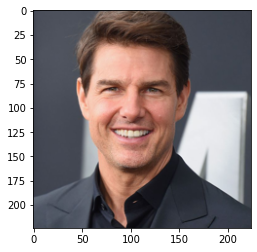

In [64]:
# Let's check if the Model predicted that right
plt.imshow(img)

In [67]:
# Make Prediction on Image
img2 = np.expand_dims(img2, axis=0)
pred = model.predict(img2)

print('Male' if pred > 0.5 else 'Female')

Female


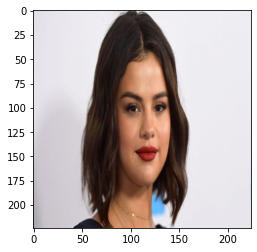

In [65]:
# Let's check if the Model predicted that right
plt.imshow(img2)